# Mask R-CNN - Train on Jets

In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Found GPU at: /device:GPU:0


In [4]:
import os
import h5py
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage

from config import Config
import utils
import model as modellib
import visualize
from model import log
import keras
#from keras.callbacks import TensorBoard

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd() # returns current working directory
print('root directory: ' + ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print('model directory: ' + MODEL_DIR)

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
print('COCO model path: ' + COCO_MODEL_PATH)
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

root directory: /home/camila/cs230/Jets_1
model directory: /home/camila/cs230/Jets_1/logs
COCO model path: /home/camila/cs230/Jets_1/mask_rcnn_coco.h5


## Configurations

In [6]:
class JetsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "jets"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    # No mini-masks
    USE_MINI_MASK = False

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    #XXXXXXXXXXXXXXXXXXX Change?

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = JetsConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]
 [ 1  1]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  64
IMAGE_MIN_DIM                  64
IMAGE_PADDING                  True
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           jets
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_POSITIV

## Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [8]:
class JetsDataset(utils.Dataset):
    """
    ...
    """

    def load_data(self, m, images, labels):
        self.add_class('jets', 1, 'jet')
        
        for i in range(m):
            image = images[i,:,:].reshape(64,64)
            label = labels[i,:,:].reshape(64,64)
            self.add_image('jets', i, path=None, image=image, label=label)
        
    
    def load_image(self, image_id):
        """
        Returns the input image
        """
        info = self.image_info[image_id]
        image = info['image']
        
        image = np.round(image * (255/np.max(image)))
        
        image3D = np.zeros((image.shape[0], image.shape[1], 3))
        image3D[:,:,0] = image
        image3D[:,:,1] = image
        image3D[:,:,2] = image

        image3D = image3D.astype(np.uint8)
        
        return image3D
        

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "jets":
            return info["image"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        label = info['label']
        shape = label.shape
        num_jets = np.max(label).astype(int)
        masks = np.zeros((shape[0], shape[1], num_jets)).astype(np.int32)
        
        for i in range(num_jets):
            masks[:,:,i] = (label == i+1)
                          
        class_ids = np.ones(num_jets, dtype=np.int32)
        
        return masks, class_ids

In [10]:
images = np.load('pixel_image_pt.npy')
labels = np.load('labels_20pt.npy')

#separating training/validation
train_cutoff = int(0.99 * images.shape[0])
images_train = images[:train_cutoff,:,:]
images_val = images[train_cutoff:,:,:]
labels_train = labels[:train_cutoff,:,:]
labels_val = labels[train_cutoff:,:,:]

# Training dataset
m_train = images_train.shape[0]
dataset_train = JetsDataset()
dataset_train.load_data(m_train, images_train, labels_train)
dataset_train.prepare()

# Validation dataset
m_val = images_val.shape[0]
dataset_val = JetsDataset()
dataset_val.load_data(m_val, images_val, labels_val)
dataset_val.prepare()

In [20]:
print(images_train.shape)
print(images_val.shape)

(990, 64, 64)
(10, 64, 64)


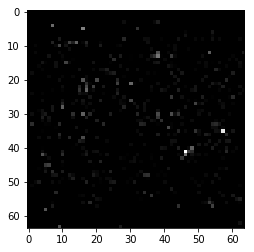

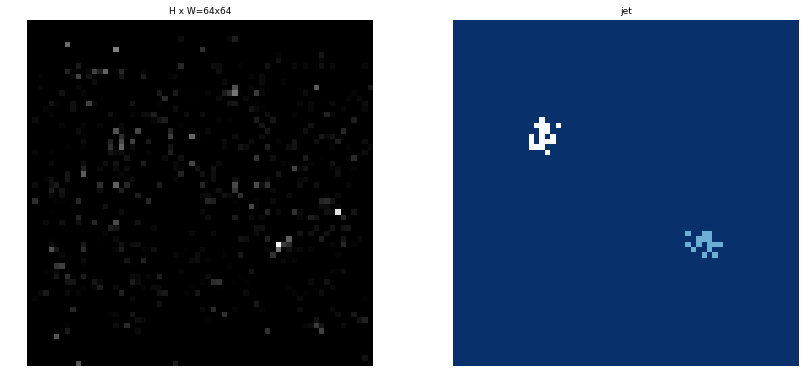

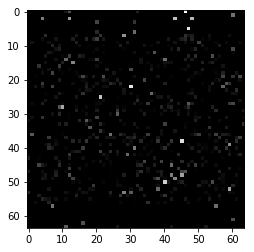

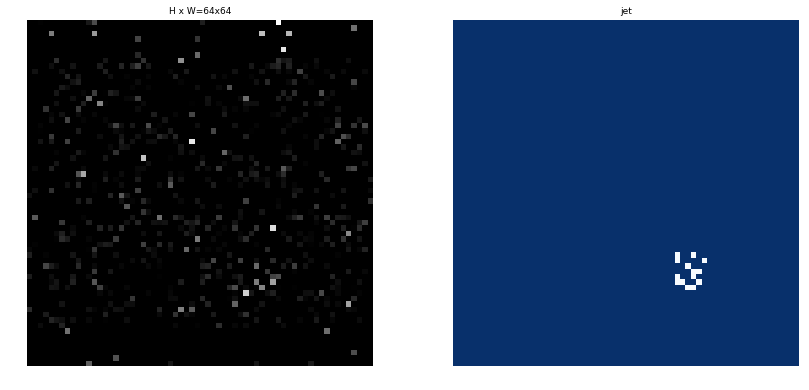

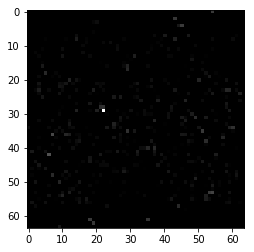

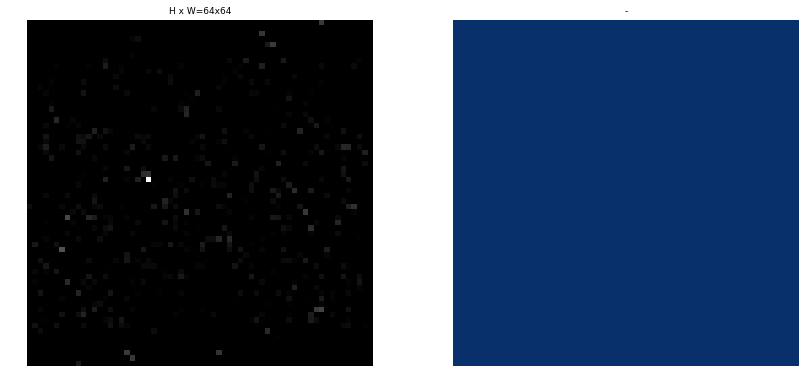

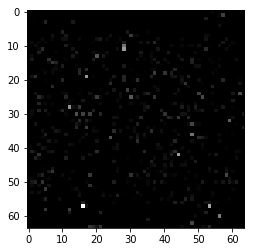

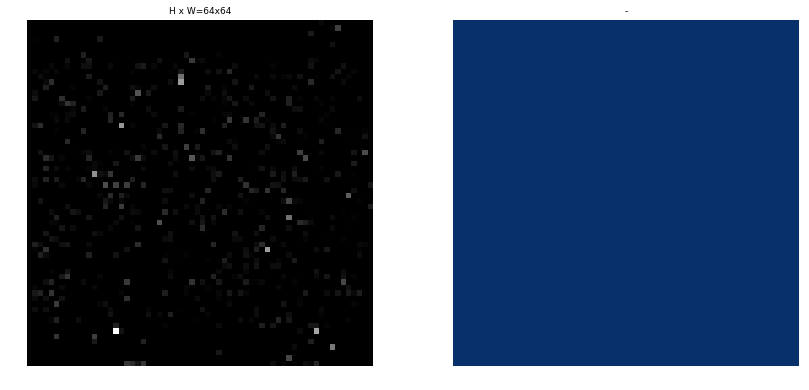

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    plt.imshow(image)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

## Create Model

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    print(model.find_last()[1])
    model.load_weights(model.find_last()[1], by_name=True)
elif init_with == "other":
    path_weights = 'weights_100k_20GeV_COCO.h5'
    model.load_weights(path_weights, by_name = True)

#path_weights = "run1_100k_10GeV_0128.h5"
#model.load_weights(path_weights)

NameError: name 'model' is not defined

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [13]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
num_epochs = 5001

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=num_epochs, 
            layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/camila/cs230/Jets_1/logs/jets20180312T2039/mask_rcnn_jets_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branc

/home/camila/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/camila/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5001
100/100 [==============================] - 76s 756ms/step - loss: 5.6792 - rpn_class_loss: 0.5101 - rpn_bbox_loss: 2.6871 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 1.6170 - mrcnn_mask_loss: 0.5890 - val_loss: 2.2561 - val_rpn_class_loss: 0.0884 - val_rpn_bbox_loss: 1.0615 - val_mrcnn_class_loss: 0.0987 - val_mrcnn_bbox_loss: 0.4408 - val_mrcnn_mask_loss: 0.5666
Epoch 2/5001
100/100 [==============================] - 45s 453ms/step - loss: 2.5839 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.2829 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.5752 - mrcnn_mask_loss: 0.5489 - val_loss: 2.3084 - val_rpn_class_loss: 0.0731 - val_rpn_bbox_loss: 0.9712 - val_mrcnn_class_loss: 0.1223 - val_mrcnn_bbox_loss: 0.5954 - val_mrcnn_mask_loss: 0.5463
Epoch 3/5001
100/100 [==============================] - 44s 439ms/step - loss: 2.4365 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.2125 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.5345 - mrcnn_mask_loss: 0.5407 - val_loss: 2.2586 - val

100/100 [==============================] - 42s 422ms/step - loss: 1.6859 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.7881 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.3631 - mrcnn_mask_loss: 0.4554 - val_loss: 1.5083 - val_rpn_class_loss: 0.0197 - val_rpn_bbox_loss: 0.6682 - val_mrcnn_class_loss: 0.0403 - val_mrcnn_bbox_loss: 0.3530 - val_mrcnn_mask_loss: 0.4270
Epoch 44/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.6427 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.7429 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.3674 - mrcnn_mask_loss: 0.4564 - val_loss: 1.5094 - val_rpn_class_loss: 0.0169 - val_rpn_bbox_loss: 0.6641 - val_mrcnn_class_loss: 0.0184 - val_mrcnn_bbox_loss: 0.3729 - val_mrcnn_mask_loss: 0.4370
Epoch 45/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.6388 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.7448 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.3751 - mrcnn_mask_loss: 0.4464 - val_loss: 1.4047 - val_rpn_class_

100/100 [==============================] - 42s 419ms/step - loss: 1.5781 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7071 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.3644 - mrcnn_mask_loss: 0.4456 - val_loss: 1.3961 - val_rpn_class_loss: 0.0132 - val_rpn_bbox_loss: 0.5083 - val_mrcnn_class_loss: 0.0587 - val_mrcnn_bbox_loss: 0.3711 - val_mrcnn_mask_loss: 0.4448
Epoch 86/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.5502 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.6811 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.3557 - mrcnn_mask_loss: 0.4483 - val_loss: 1.4468 - val_rpn_class_loss: 0.0147 - val_rpn_bbox_loss: 0.5467 - val_mrcnn_class_loss: 0.0603 - val_mrcnn_bbox_loss: 0.3962 - val_mrcnn_mask_loss: 0.4289
Epoch 87/5001
100/100 [==============================] - 42s 419ms/step - loss: 1.5419 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.6835 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.3490 - mrcnn_mask_loss: 0.4464 - val_loss: 1.4540 - val_rpn_class_

100/100 [==============================] - 46s 463ms/step - loss: 1.5114 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.6640 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.3432 - mrcnn_mask_loss: 0.4412 - val_loss: 1.2545 - val_rpn_class_loss: 0.0121 - val_rpn_bbox_loss: 0.4438 - val_mrcnn_class_loss: 0.0389 - val_mrcnn_bbox_loss: 0.3428 - val_mrcnn_mask_loss: 0.4170
Epoch 128/5001
100/100 [==============================] - 47s 467ms/step - loss: 1.5956 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7341 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3561 - mrcnn_mask_loss: 0.4409 - val_loss: 1.4133 - val_rpn_class_loss: 0.0134 - val_rpn_bbox_loss: 0.5365 - val_mrcnn_class_loss: 0.0479 - val_mrcnn_bbox_loss: 0.3594 - val_mrcnn_mask_loss: 0.4561
Epoch 129/5001
100/100 [==============================] - 46s 457ms/step - loss: 1.5627 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7031 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.3542 - mrcnn_mask_loss: 0.4411 - val_loss: 1.3623 - val_rpn_clas

100/100 [==============================] - 42s 419ms/step - loss: 1.4155 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5835 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.3386 - mrcnn_mask_loss: 0.4391 - val_loss: 1.3147 - val_rpn_class_loss: 0.0109 - val_rpn_bbox_loss: 0.4676 - val_mrcnn_class_loss: 0.0366 - val_mrcnn_bbox_loss: 0.3578 - val_mrcnn_mask_loss: 0.4417
Epoch 170/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.4888 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6378 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.3502 - mrcnn_mask_loss: 0.4417 - val_loss: 1.3710 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.4998 - val_mrcnn_class_loss: 0.0544 - val_mrcnn_bbox_loss: 0.3662 - val_mrcnn_mask_loss: 0.4391
Epoch 171/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.4770 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6411 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.4398 - val_loss: 1.3664 - val_rpn_clas

100/100 [==============================] - 42s 418ms/step - loss: 1.4431 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6166 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.3365 - mrcnn_mask_loss: 0.4344 - val_loss: 1.3453 - val_rpn_class_loss: 0.0111 - val_rpn_bbox_loss: 0.5422 - val_mrcnn_class_loss: 0.0487 - val_mrcnn_bbox_loss: 0.3387 - val_mrcnn_mask_loss: 0.4046
Epoch 212/5001
100/100 [==============================] - 42s 417ms/step - loss: 1.4429 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.5921 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.3518 - mrcnn_mask_loss: 0.4414 - val_loss: 1.3512 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.5632 - val_mrcnn_class_loss: 0.0443 - val_mrcnn_bbox_loss: 0.3045 - val_mrcnn_mask_loss: 0.4290
Epoch 213/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.4240 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5850 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.3468 - mrcnn_mask_loss: 0.4401 - val_loss: 1.2502 - val_rpn_clas

100/100 [==============================] - 42s 417ms/step - loss: 1.4479 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5978 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.3565 - mrcnn_mask_loss: 0.4346 - val_loss: 1.3047 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.4886 - val_mrcnn_class_loss: 0.0575 - val_mrcnn_bbox_loss: 0.3248 - val_mrcnn_mask_loss: 0.4237
Epoch 254/5001
100/100 [==============================] - 42s 419ms/step - loss: 1.5034 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.6565 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.3469 - mrcnn_mask_loss: 0.4381 - val_loss: 1.4355 - val_rpn_class_loss: 0.0113 - val_rpn_bbox_loss: 0.6109 - val_mrcnn_class_loss: 0.0366 - val_mrcnn_bbox_loss: 0.3454 - val_mrcnn_mask_loss: 0.4312
Epoch 255/5001
100/100 [==============================] - 42s 415ms/step - loss: 1.4218 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5836 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.3417 - mrcnn_mask_loss: 0.4387 - val_loss: 1.3673 - val_rpn_clas

100/100 [==============================] - 42s 421ms/step - loss: 1.4730 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6404 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.3397 - mrcnn_mask_loss: 0.4371 - val_loss: 1.3939 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.6063 - val_mrcnn_class_loss: 0.0182 - val_mrcnn_bbox_loss: 0.3271 - val_mrcnn_mask_loss: 0.4327
Epoch 296/5001
100/100 [==============================] - 42s 419ms/step - loss: 1.4497 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6174 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.3386 - mrcnn_mask_loss: 0.4372 - val_loss: 1.2719 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.5047 - val_mrcnn_class_loss: 0.0361 - val_mrcnn_bbox_loss: 0.2912 - val_mrcnn_mask_loss: 0.4298
Epoch 297/5001
100/100 [==============================] - 42s 417ms/step - loss: 1.4047 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5732 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.3387 - mrcnn_mask_loss: 0.4361 - val_loss: 1.4017 - val_rpn_clas

100/100 [==============================] - 42s 419ms/step - loss: 1.4520 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6314 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.3335 - mrcnn_mask_loss: 0.4337 - val_loss: 1.3125 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.5281 - val_mrcnn_class_loss: 0.0394 - val_mrcnn_bbox_loss: 0.3316 - val_mrcnn_mask_loss: 0.4042
Epoch 338/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.4472 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.6218 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.3409 - mrcnn_mask_loss: 0.4332 - val_loss: 1.3158 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.5785 - val_mrcnn_class_loss: 0.0427 - val_mrcnn_bbox_loss: 0.3038 - val_mrcnn_mask_loss: 0.3812
Epoch 339/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.4100 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5895 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.3379 - mrcnn_mask_loss: 0.4245 - val_loss: 1.3791 - val_rpn_clas

100/100 [==============================] - 42s 416ms/step - loss: 1.4014 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.6025 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.3197 - mrcnn_mask_loss: 0.4268 - val_loss: 1.2588 - val_rpn_class_loss: 0.0113 - val_rpn_bbox_loss: 0.4770 - val_mrcnn_class_loss: 0.0174 - val_mrcnn_bbox_loss: 0.3420 - val_mrcnn_mask_loss: 0.4111
Epoch 380/5001
100/100 [==============================] - 42s 419ms/step - loss: 1.3871 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5737 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.3332 - mrcnn_mask_loss: 0.4302 - val_loss: 1.2482 - val_rpn_class_loss: 0.0089 - val_rpn_bbox_loss: 0.4807 - val_mrcnn_class_loss: 0.0551 - val_mrcnn_bbox_loss: 0.2862 - val_mrcnn_mask_loss: 0.4173
Epoch 381/5001
100/100 [==============================] - 42s 419ms/step - loss: 1.4137 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5966 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.3345 - mrcnn_mask_loss: 0.4295 - val_loss: 1.2960 - val_rpn_clas

100/100 [==============================] - 42s 419ms/step - loss: 1.3880 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.5860 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.4266 - val_loss: 1.2835 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 0.5298 - val_mrcnn_class_loss: 0.0311 - val_mrcnn_bbox_loss: 0.3138 - val_mrcnn_mask_loss: 0.3990
Epoch 422/5001
100/100 [==============================] - 42s 418ms/step - loss: 1.4417 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.6368 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.3252 - mrcnn_mask_loss: 0.4303 - val_loss: 1.3602 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.5500 - val_mrcnn_class_loss: 0.0560 - val_mrcnn_bbox_loss: 0.3123 - val_mrcnn_mask_loss: 0.4326
Epoch 423/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.4141 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.6149 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.3247 - mrcnn_mask_loss: 0.4296 - val_loss: 1.3079 - val_rpn_clas

100/100 [==============================] - 42s 419ms/step - loss: 1.3345 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.5410 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.3191 - mrcnn_mask_loss: 0.4266 - val_loss: 1.2836 - val_rpn_class_loss: 0.0104 - val_rpn_bbox_loss: 0.5261 - val_mrcnn_class_loss: 0.0215 - val_mrcnn_bbox_loss: 0.3221 - val_mrcnn_mask_loss: 0.4036
Epoch 464/5001
100/100 [==============================] - 42s 417ms/step - loss: 1.3794 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.5811 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.3155 - mrcnn_mask_loss: 0.4324 - val_loss: 1.2684 - val_rpn_class_loss: 0.0105 - val_rpn_bbox_loss: 0.4936 - val_mrcnn_class_loss: 0.0651 - val_mrcnn_bbox_loss: 0.2910 - val_mrcnn_mask_loss: 0.4083
Epoch 465/5001
100/100 [==============================] - 42s 419ms/step - loss: 1.4133 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.6120 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.4291 - val_loss: 1.1934 - val_rpn_clas

100/100 [==============================] - 42s 421ms/step - loss: 1.3305 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5347 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.3246 - mrcnn_mask_loss: 0.4215 - val_loss: 1.2219 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.4807 - val_mrcnn_class_loss: 0.0139 - val_mrcnn_bbox_loss: 0.3173 - val_mrcnn_mask_loss: 0.4012
Epoch 506/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.3257 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.5358 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.3198 - mrcnn_mask_loss: 0.4243 - val_loss: 1.1879 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.4430 - val_mrcnn_class_loss: 0.0118 - val_mrcnn_bbox_loss: 0.3013 - val_mrcnn_mask_loss: 0.4223
Epoch 507/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.3231 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5273 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.3179 - mrcnn_mask_loss: 0.4248 - val_loss: 1.2336 - val_rpn_clas

100/100 [==============================] - 42s 421ms/step - loss: 1.3497 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5492 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.3251 - mrcnn_mask_loss: 0.4265 - val_loss: 1.3324 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.5437 - val_mrcnn_class_loss: 0.0307 - val_mrcnn_bbox_loss: 0.3353 - val_mrcnn_mask_loss: 0.4134
Epoch 548/5001
100/100 [==============================] - 42s 418ms/step - loss: 1.4303 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.6276 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.3206 - mrcnn_mask_loss: 0.4318 - val_loss: 1.2507 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.5156 - val_mrcnn_class_loss: 0.0344 - val_mrcnn_bbox_loss: 0.2990 - val_mrcnn_mask_loss: 0.3921
Epoch 549/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.3084 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.5094 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.3160 - mrcnn_mask_loss: 0.4291 - val_loss: 1.2197 - val_rpn_clas

100/100 [==============================] - 43s 425ms/step - loss: 1.2851 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5079 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.3098 - mrcnn_mask_loss: 0.4242 - val_loss: 1.2100 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.4770 - val_mrcnn_class_loss: 0.0322 - val_mrcnn_bbox_loss: 0.2913 - val_mrcnn_mask_loss: 0.4001
Epoch 590/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.3535 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5655 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.3154 - mrcnn_mask_loss: 0.4233 - val_loss: 1.2372 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 0.4701 - val_mrcnn_class_loss: 0.0343 - val_mrcnn_bbox_loss: 0.3082 - val_mrcnn_mask_loss: 0.4149
Epoch 591/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.3212 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.3162 - mrcnn_mask_loss: 0.4208 - val_loss: 1.2461 - val_rpn_clas

100/100 [==============================] - 42s 423ms/step - loss: 1.3317 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.5530 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.3119 - mrcnn_mask_loss: 0.4196 - val_loss: 1.1986 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.4497 - val_mrcnn_class_loss: 0.0116 - val_mrcnn_bbox_loss: 0.3216 - val_mrcnn_mask_loss: 0.4073
Epoch 632/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.2848 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5018 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.3112 - mrcnn_mask_loss: 0.4238 - val_loss: 1.2358 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.4934 - val_mrcnn_class_loss: 0.0482 - val_mrcnn_bbox_loss: 0.2958 - val_mrcnn_mask_loss: 0.3889
Epoch 633/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.2952 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.5171 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.4170 - val_loss: 1.2242 - val_rpn_clas

100/100 [==============================] - 42s 421ms/step - loss: 1.2910 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.5186 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.4204 - val_loss: 1.1631 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.4320 - val_mrcnn_class_loss: 0.0159 - val_mrcnn_bbox_loss: 0.3138 - val_mrcnn_mask_loss: 0.3922
Epoch 674/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.3338 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.5512 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.3171 - mrcnn_mask_loss: 0.4217 - val_loss: 1.1091 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.4434 - val_mrcnn_class_loss: 0.0284 - val_mrcnn_bbox_loss: 0.2596 - val_mrcnn_mask_loss: 0.3682
Epoch 675/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.3151 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.5350 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.3160 - mrcnn_mask_loss: 0.4198 - val_loss: 1.1772 - val_rpn_clas

100/100 [==============================] - 42s 422ms/step - loss: 1.3124 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.3130 - mrcnn_mask_loss: 0.4190 - val_loss: 1.2565 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.4460 - val_mrcnn_class_loss: 0.0456 - val_mrcnn_bbox_loss: 0.3477 - val_mrcnn_mask_loss: 0.4080
Epoch 716/5001
100/100 [==============================] - 43s 426ms/step - loss: 1.3098 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.5318 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.3060 - mrcnn_mask_loss: 0.4172 - val_loss: 1.1336 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.4063 - val_mrcnn_class_loss: 0.0344 - val_mrcnn_bbox_loss: 0.2810 - val_mrcnn_mask_loss: 0.4032
Epoch 717/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.3739 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.5822 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.3211 - mrcnn_mask_loss: 0.4225 - val_loss: 1.2023 - val_rpn_clas

100/100 [==============================] - 42s 423ms/step - loss: 1.3273 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5477 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.3100 - mrcnn_mask_loss: 0.4235 - val_loss: 1.2547 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.5110 - val_mrcnn_class_loss: 0.0445 - val_mrcnn_bbox_loss: 0.3086 - val_mrcnn_mask_loss: 0.3816
Epoch 758/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.3890 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5972 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.3186 - mrcnn_mask_loss: 0.4247 - val_loss: 1.1960 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.4685 - val_mrcnn_class_loss: 0.0438 - val_mrcnn_bbox_loss: 0.2863 - val_mrcnn_mask_loss: 0.3888
Epoch 759/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.3174 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5314 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.3095 - mrcnn_mask_loss: 0.4256 - val_loss: 1.1935 - val_rpn_clas

100/100 [==============================] - 42s 422ms/step - loss: 1.2988 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5083 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.3160 - mrcnn_mask_loss: 0.4262 - val_loss: 1.2028 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.4378 - val_mrcnn_class_loss: 0.0380 - val_mrcnn_bbox_loss: 0.3326 - val_mrcnn_mask_loss: 0.3858
Epoch 800/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.3428 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.5678 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.3121 - mrcnn_mask_loss: 0.4174 - val_loss: 1.1553 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.4432 - val_mrcnn_class_loss: 0.0225 - val_mrcnn_bbox_loss: 0.2900 - val_mrcnn_mask_loss: 0.3908
Epoch 801/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2976 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.5094 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.3172 - mrcnn_mask_loss: 0.4248 - val_loss: 1.2300 - val_rpn_clas

100/100 [==============================] - 42s 421ms/step - loss: 1.2901 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5015 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.3220 - mrcnn_mask_loss: 0.4239 - val_loss: 1.2507 - val_rpn_class_loss: 0.0098 - val_rpn_bbox_loss: 0.4530 - val_mrcnn_class_loss: 0.0601 - val_mrcnn_bbox_loss: 0.3290 - val_mrcnn_mask_loss: 0.3988
Epoch 842/5001
100/100 [==============================] - 42s 425ms/step - loss: 1.2739 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4941 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.3100 - mrcnn_mask_loss: 0.4233 - val_loss: 1.1469 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.4101 - val_mrcnn_class_loss: 0.0380 - val_mrcnn_bbox_loss: 0.2965 - val_mrcnn_mask_loss: 0.3937
Epoch 843/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.3333 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.5433 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.3138 - mrcnn_mask_loss: 0.4261 - val_loss: 1.1826 - val_rpn_clas

100/100 [==============================] - 42s 425ms/step - loss: 1.2703 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4917 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.3123 - mrcnn_mask_loss: 0.4224 - val_loss: 1.2886 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 0.5514 - val_mrcnn_class_loss: 0.0444 - val_mrcnn_bbox_loss: 0.3051 - val_mrcnn_mask_loss: 0.3777
Epoch 884/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2778 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.5019 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.3119 - mrcnn_mask_loss: 0.4223 - val_loss: 1.2624 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.5175 - val_mrcnn_class_loss: 0.0325 - val_mrcnn_bbox_loss: 0.3224 - val_mrcnn_mask_loss: 0.3808
Epoch 885/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2706 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5019 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.3019 - mrcnn_mask_loss: 0.4225 - val_loss: 1.2970 - val_rpn_clas

100/100 [==============================] - 42s 424ms/step - loss: 1.2919 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5051 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.3178 - mrcnn_mask_loss: 0.4234 - val_loss: 1.2125 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.4207 - val_mrcnn_class_loss: 0.0546 - val_mrcnn_bbox_loss: 0.3266 - val_mrcnn_mask_loss: 0.4019
Epoch 926/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.2974 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.5192 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.3111 - mrcnn_mask_loss: 0.4191 - val_loss: 1.1212 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.4381 - val_mrcnn_class_loss: 0.0198 - val_mrcnn_bbox_loss: 0.2697 - val_mrcnn_mask_loss: 0.3840
Epoch 927/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.3232 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.5383 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.3154 - mrcnn_mask_loss: 0.4238 - val_loss: 1.2571 - val_rpn_clas

100/100 [==============================] - 43s 428ms/step - loss: 1.2955 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.5065 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.3157 - mrcnn_mask_loss: 0.4230 - val_loss: 1.2023 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.4743 - val_mrcnn_class_loss: 0.0374 - val_mrcnn_bbox_loss: 0.2885 - val_mrcnn_mask_loss: 0.3922
Epoch 968/5001
100/100 [==============================] - 42s 425ms/step - loss: 1.2711 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4876 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.3130 - mrcnn_mask_loss: 0.4218 - val_loss: 1.1510 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.3893 - val_mrcnn_class_loss: 0.0293 - val_mrcnn_bbox_loss: 0.3161 - val_mrcnn_mask_loss: 0.4075
Epoch 969/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.3019 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.5111 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.3223 - mrcnn_mask_loss: 0.4218 - val_loss: 1.2859 - val_rpn_clas

100/100 [==============================] - 42s 424ms/step - loss: 1.2626 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4955 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.4157 - val_loss: 1.1803 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.4419 - val_mrcnn_class_loss: 0.0116 - val_mrcnn_bbox_loss: 0.3171 - val_mrcnn_mask_loss: 0.4003
Epoch 1010/5001
100/100 [==============================] - 42s 425ms/step - loss: 1.2819 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.5067 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.3132 - mrcnn_mask_loss: 0.4165 - val_loss: 1.1737 - val_rpn_class_loss: 0.0098 - val_rpn_bbox_loss: 0.4487 - val_mrcnn_class_loss: 0.0060 - val_mrcnn_bbox_loss: 0.3014 - val_mrcnn_mask_loss: 0.4077
Epoch 1011/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.2905 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.5156 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.3169 - mrcnn_mask_loss: 0.4156 - val_loss: 1.1633 - val_rpn_cl

100/100 [==============================] - 42s 424ms/step - loss: 1.2957 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5222 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.3092 - mrcnn_mask_loss: 0.4216 - val_loss: 1.2499 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.5152 - val_mrcnn_class_loss: 0.0372 - val_mrcnn_bbox_loss: 0.2876 - val_mrcnn_mask_loss: 0.4009
Epoch 1052/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.2784 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5014 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.3149 - mrcnn_mask_loss: 0.4185 - val_loss: 1.2537 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.4539 - val_mrcnn_class_loss: 0.0704 - val_mrcnn_bbox_loss: 0.3111 - val_mrcnn_mask_loss: 0.4098
Epoch 1053/5001
100/100 [==============================] - 43s 425ms/step - loss: 1.2918 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5078 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.3171 - mrcnn_mask_loss: 0.4212 - val_loss: 1.2105 - val_rpn_cl

100/100 [==============================] - 44s 441ms/step - loss: 1.2844 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5052 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.3154 - mrcnn_mask_loss: 0.4187 - val_loss: 1.1750 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.4548 - val_mrcnn_class_loss: 0.0301 - val_mrcnn_bbox_loss: 0.2862 - val_mrcnn_mask_loss: 0.3948
Epoch 1094/5001
100/100 [==============================] - 44s 439ms/step - loss: 1.2815 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.5114 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.4201 - val_loss: 1.2246 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 0.4981 - val_mrcnn_class_loss: 0.0265 - val_mrcnn_bbox_loss: 0.3127 - val_mrcnn_mask_loss: 0.3770
Epoch 1095/5001
100/100 [==============================] - 44s 441ms/step - loss: 1.3318 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.5586 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.3103 - mrcnn_mask_loss: 0.4168 - val_loss: 1.2477 - val_rpn_cl

100/100 [==============================] - 42s 424ms/step - loss: 1.2790 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4995 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.3177 - mrcnn_mask_loss: 0.4192 - val_loss: 1.2778 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.5270 - val_mrcnn_class_loss: 0.0362 - val_mrcnn_bbox_loss: 0.3241 - val_mrcnn_mask_loss: 0.3808
Epoch 1136/5001
100/100 [==============================] - 43s 425ms/step - loss: 1.2879 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.5178 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.3089 - mrcnn_mask_loss: 0.4187 - val_loss: 1.2223 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.4734 - val_mrcnn_class_loss: 0.0147 - val_mrcnn_bbox_loss: 0.3233 - val_mrcnn_mask_loss: 0.4018
Epoch 1137/5001
100/100 [==============================] - 43s 426ms/step - loss: 1.2889 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.5042 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.3240 - mrcnn_mask_loss: 0.4202 - val_loss: 1.2085 - val_rpn_cl

100/100 [==============================] - 43s 427ms/step - loss: 1.2450 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4795 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.3042 - mrcnn_mask_loss: 0.4186 - val_loss: 1.1637 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.4408 - val_mrcnn_class_loss: 0.0277 - val_mrcnn_bbox_loss: 0.2995 - val_mrcnn_mask_loss: 0.3872
Epoch 1178/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2873 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.5203 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.3031 - mrcnn_mask_loss: 0.4194 - val_loss: 1.2002 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.4770 - val_mrcnn_class_loss: 0.0461 - val_mrcnn_bbox_loss: 0.2963 - val_mrcnn_mask_loss: 0.3717
Epoch 1179/5001
100/100 [==============================] - 43s 425ms/step - loss: 1.2669 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.5011 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.3100 - mrcnn_mask_loss: 0.4169 - val_loss: 1.2220 - val_rpn_cl

100/100 [==============================] - 42s 423ms/step - loss: 1.2780 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5039 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.3100 - mrcnn_mask_loss: 0.4184 - val_loss: 1.2373 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.5291 - val_mrcnn_class_loss: 0.0286 - val_mrcnn_bbox_loss: 0.2921 - val_mrcnn_mask_loss: 0.3780
Epoch 1220/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2461 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4879 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.3011 - mrcnn_mask_loss: 0.4141 - val_loss: 1.2491 - val_rpn_class_loss: 0.0098 - val_rpn_bbox_loss: 0.4813 - val_mrcnn_class_loss: 0.0240 - val_mrcnn_bbox_loss: 0.3292 - val_mrcnn_mask_loss: 0.4047
Epoch 1221/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2810 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5121 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.4219 - val_loss: 1.1994 - val_rpn_cl

100/100 [==============================] - 42s 425ms/step - loss: 1.2480 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4836 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.4185 - val_loss: 1.2447 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.4695 - val_mrcnn_class_loss: 0.0414 - val_mrcnn_bbox_loss: 0.3405 - val_mrcnn_mask_loss: 0.3840
Epoch 1262/5001
100/100 [==============================] - 43s 427ms/step - loss: 1.2520 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4954 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.4144 - val_loss: 1.2455 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.4676 - val_mrcnn_class_loss: 0.0128 - val_mrcnn_bbox_loss: 0.3506 - val_mrcnn_mask_loss: 0.4054
Epoch 1263/5001
100/100 [==============================] - 43s 425ms/step - loss: 1.2513 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4773 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.3101 - mrcnn_mask_loss: 0.4210 - val_loss: 1.2875 - val_rpn_cl

100/100 [==============================] - 43s 427ms/step - loss: 1.2917 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.5196 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.4171 - val_loss: 1.2168 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.4927 - val_mrcnn_class_loss: 0.0336 - val_mrcnn_bbox_loss: 0.2941 - val_mrcnn_mask_loss: 0.3873
Epoch 1304/5001
100/100 [==============================] - 43s 428ms/step - loss: 1.2811 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5098 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.4237 - val_loss: 1.1864 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.4460 - val_mrcnn_class_loss: 0.0463 - val_mrcnn_bbox_loss: 0.3063 - val_mrcnn_mask_loss: 0.3789
Epoch 1305/5001
100/100 [==============================] - 43s 431ms/step - loss: 1.2513 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4883 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.3128 - mrcnn_mask_loss: 0.4126 - val_loss: 1.2476 - val_rpn_cl

100/100 [==============================] - 46s 461ms/step - loss: 1.2676 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4966 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.3108 - mrcnn_mask_loss: 0.4178 - val_loss: 1.2391 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.4896 - val_mrcnn_class_loss: 0.0524 - val_mrcnn_bbox_loss: 0.2923 - val_mrcnn_mask_loss: 0.3949
Epoch 1346/5001
100/100 [==============================] - 45s 449ms/step - loss: 1.2550 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5046 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 0.4110 - val_loss: 1.2065 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.4857 - val_mrcnn_class_loss: 0.0341 - val_mrcnn_bbox_loss: 0.2904 - val_mrcnn_mask_loss: 0.3870
Epoch 1347/5001
100/100 [==============================] - 43s 429ms/step - loss: 1.2710 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4962 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.3099 - mrcnn_mask_loss: 0.4193 - val_loss: 1.2272 - val_rpn_cl

100/100 [==============================] - 43s 426ms/step - loss: 1.2523 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4923 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.3063 - mrcnn_mask_loss: 0.4097 - val_loss: 1.2651 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.4917 - val_mrcnn_class_loss: 0.0202 - val_mrcnn_bbox_loss: 0.3404 - val_mrcnn_mask_loss: 0.4035
Epoch 1388/5001
100/100 [==============================] - 43s 429ms/step - loss: 1.2740 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5139 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.3040 - mrcnn_mask_loss: 0.4173 - val_loss: 1.2096 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.4802 - val_mrcnn_class_loss: 0.0173 - val_mrcnn_bbox_loss: 0.3090 - val_mrcnn_mask_loss: 0.3942
Epoch 1389/5001
100/100 [==============================] - 42s 425ms/step - loss: 1.2919 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.5205 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.3085 - mrcnn_mask_loss: 0.4160 - val_loss: 1.2069 - val_rpn_cl

100/100 [==============================] - 43s 426ms/step - loss: 1.2878 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.5159 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.3082 - mrcnn_mask_loss: 0.4197 - val_loss: 1.2223 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.4511 - val_mrcnn_class_loss: 0.0289 - val_mrcnn_bbox_loss: 0.3309 - val_mrcnn_mask_loss: 0.4017
Epoch 1430/5001
100/100 [==============================] - 43s 433ms/step - loss: 1.2423 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4731 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 0.4202 - val_loss: 1.2660 - val_rpn_class_loss: 0.0106 - val_rpn_bbox_loss: 0.5312 - val_mrcnn_class_loss: 0.0264 - val_mrcnn_bbox_loss: 0.3013 - val_mrcnn_mask_loss: 0.3965
Epoch 1431/5001
100/100 [==============================] - 43s 426ms/step - loss: 1.2768 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.5038 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.3163 - mrcnn_mask_loss: 0.4134 - val_loss: 1.2619 - val_rpn_cl

100/100 [==============================] - 43s 426ms/step - loss: 1.2552 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4941 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.3045 - mrcnn_mask_loss: 0.4138 - val_loss: 1.2817 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.5270 - val_mrcnn_class_loss: 0.0478 - val_mrcnn_bbox_loss: 0.3100 - val_mrcnn_mask_loss: 0.3873
Epoch 1472/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2578 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4891 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.4252 - val_loss: 1.2995 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.5119 - val_mrcnn_class_loss: 0.0224 - val_mrcnn_bbox_loss: 0.3500 - val_mrcnn_mask_loss: 0.4069
Epoch 1473/5001
100/100 [==============================] - 42s 425ms/step - loss: 1.2587 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4964 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.3061 - mrcnn_mask_loss: 0.4151 - val_loss: 1.2267 - val_rpn_cl

100/100 [==============================] - 43s 426ms/step - loss: 1.2246 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4665 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.4152 - val_loss: 1.2953 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.5285 - val_mrcnn_class_loss: 0.0357 - val_mrcnn_bbox_loss: 0.3239 - val_mrcnn_mask_loss: 0.3976
Epoch 1514/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2510 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4907 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.4144 - val_loss: 1.3192 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.5638 - val_mrcnn_class_loss: 0.0321 - val_mrcnn_bbox_loss: 0.3314 - val_mrcnn_mask_loss: 0.3829
Epoch 1515/5001
100/100 [==============================] - 43s 426ms/step - loss: 1.2400 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4770 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.3086 - mrcnn_mask_loss: 0.4133 - val_loss: 1.2784 - val_rpn_cl

100/100 [==============================] - 43s 425ms/step - loss: 1.2282 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4653 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.3036 - mrcnn_mask_loss: 0.4187 - val_loss: 1.2514 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.5543 - val_mrcnn_class_loss: 0.0138 - val_mrcnn_bbox_loss: 0.2890 - val_mrcnn_mask_loss: 0.3857
Epoch 1556/5001
100/100 [==============================] - 42s 425ms/step - loss: 1.2402 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4800 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.3089 - mrcnn_mask_loss: 0.4137 - val_loss: 1.2653 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.5227 - val_mrcnn_class_loss: 0.0479 - val_mrcnn_bbox_loss: 0.3043 - val_mrcnn_mask_loss: 0.3816
Epoch 1557/5001
100/100 [==============================] - 43s 426ms/step - loss: 1.2541 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4901 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.3127 - mrcnn_mask_loss: 0.4132 - val_loss: 1.2553 - val_rpn_cl

100/100 [==============================] - 43s 427ms/step - loss: 1.2566 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4951 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.4144 - val_loss: 1.1585 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.4525 - val_mrcnn_class_loss: 0.0231 - val_mrcnn_bbox_loss: 0.2895 - val_mrcnn_mask_loss: 0.3848
Epoch 1598/5001
100/100 [==============================] - 43s 428ms/step - loss: 1.2158 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4608 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.2966 - mrcnn_mask_loss: 0.4198 - val_loss: 1.2618 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.4773 - val_mrcnn_class_loss: 0.0514 - val_mrcnn_bbox_loss: 0.3116 - val_mrcnn_mask_loss: 0.4129
Epoch 1599/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2647 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4934 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.3156 - mrcnn_mask_loss: 0.4209 - val_loss: 1.2826 - val_rpn_cl

100/100 [==============================] - 43s 425ms/step - loss: 1.2101 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4558 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.2984 - mrcnn_mask_loss: 0.4133 - val_loss: 1.1909 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 0.4932 - val_mrcnn_class_loss: 0.0128 - val_mrcnn_bbox_loss: 0.2908 - val_mrcnn_mask_loss: 0.3844
Epoch 1640/5001
100/100 [==============================] - 43s 427ms/step - loss: 1.2557 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4954 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.4140 - val_loss: 1.2457 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.4657 - val_mrcnn_class_loss: 0.0424 - val_mrcnn_bbox_loss: 0.3406 - val_mrcnn_mask_loss: 0.3873
Epoch 1641/5001
100/100 [==============================] - 43s 425ms/step - loss: 1.2349 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4786 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2997 - mrcnn_mask_loss: 0.4176 - val_loss: 1.1988 - val_rpn_cl

100/100 [==============================] - 43s 428ms/step - loss: 1.2424 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4701 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.3065 - mrcnn_mask_loss: 0.4220 - val_loss: 1.1992 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.5070 - val_mrcnn_class_loss: 0.0243 - val_mrcnn_bbox_loss: 0.2851 - val_mrcnn_mask_loss: 0.3742
Epoch 1682/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2146 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4511 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.3057 - mrcnn_mask_loss: 0.4164 - val_loss: 1.2398 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.4863 - val_mrcnn_class_loss: 0.0251 - val_mrcnn_bbox_loss: 0.3224 - val_mrcnn_mask_loss: 0.3969
Epoch 1683/5001
100/100 [==============================] - 43s 426ms/step - loss: 1.2432 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4731 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.3059 - mrcnn_mask_loss: 0.4195 - val_loss: 1.2040 - val_rpn_cl

100/100 [==============================] - 43s 427ms/step - loss: 1.2364 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4786 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.3064 - mrcnn_mask_loss: 0.4117 - val_loss: 1.3504 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.5085 - val_mrcnn_class_loss: 0.0590 - val_mrcnn_bbox_loss: 0.3483 - val_mrcnn_mask_loss: 0.4252
Epoch 1724/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.2390 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4725 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.3099 - mrcnn_mask_loss: 0.4160 - val_loss: 1.2231 - val_rpn_class_loss: 0.0081 - val_rpn_bbox_loss: 0.4454 - val_mrcnn_class_loss: 0.0268 - val_mrcnn_bbox_loss: 0.3357 - val_mrcnn_mask_loss: 0.4071
Epoch 1725/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2669 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5108 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.3052 - mrcnn_mask_loss: 0.4106 - val_loss: 1.2160 - val_rpn_cl

100/100 [==============================] - 42s 424ms/step - loss: 1.1998 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4447 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.2988 - mrcnn_mask_loss: 0.4166 - val_loss: 1.1789 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.5000 - val_mrcnn_class_loss: 0.0209 - val_mrcnn_bbox_loss: 0.2783 - val_mrcnn_mask_loss: 0.3704
Epoch 1766/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.2258 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4650 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.4174 - val_loss: 1.2431 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.4465 - val_mrcnn_class_loss: 0.0212 - val_mrcnn_bbox_loss: 0.3649 - val_mrcnn_mask_loss: 0.4013
Epoch 1767/5001
100/100 [==============================] - 42s 425ms/step - loss: 1.2574 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4928 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.3095 - mrcnn_mask_loss: 0.4166 - val_loss: 1.1779 - val_rpn_cl

100/100 [==============================] - 42s 424ms/step - loss: 1.2040 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4529 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.4125 - val_loss: 1.2751 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.5513 - val_mrcnn_class_loss: 0.0328 - val_mrcnn_bbox_loss: 0.2956 - val_mrcnn_mask_loss: 0.3862
Epoch 1808/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2547 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4945 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.3075 - mrcnn_mask_loss: 0.4141 - val_loss: 1.2579 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.5321 - val_mrcnn_class_loss: 0.0371 - val_mrcnn_bbox_loss: 0.2937 - val_mrcnn_mask_loss: 0.3854
Epoch 1809/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2368 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4754 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.3060 - mrcnn_mask_loss: 0.4143 - val_loss: 1.1740 - val_rpn_cl

100/100 [==============================] - 43s 426ms/step - loss: 1.1960 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.4408 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.4182 - val_loss: 1.2504 - val_rpn_class_loss: 0.0077 - val_rpn_bbox_loss: 0.5015 - val_mrcnn_class_loss: 0.0610 - val_mrcnn_bbox_loss: 0.2979 - val_mrcnn_mask_loss: 0.3823
Epoch 1850/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2169 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4589 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.3045 - mrcnn_mask_loss: 0.4144 - val_loss: 1.3555 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.5567 - val_mrcnn_class_loss: 0.0183 - val_mrcnn_bbox_loss: 0.3739 - val_mrcnn_mask_loss: 0.3984
Epoch 1851/5001
100/100 [==============================] - 42s 425ms/step - loss: 1.2312 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4613 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.3141 - mrcnn_mask_loss: 0.4177 - val_loss: 1.2341 - val_rpn_cl

100/100 [==============================] - 43s 425ms/step - loss: 1.2531 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4837 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.3087 - mrcnn_mask_loss: 0.4182 - val_loss: 1.2029 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.4721 - val_mrcnn_class_loss: 0.0316 - val_mrcnn_bbox_loss: 0.2967 - val_mrcnn_mask_loss: 0.3951
Epoch 1892/5001
100/100 [==============================] - 43s 426ms/step - loss: 1.1918 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4365 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.4185 - val_loss: 1.2025 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.4323 - val_mrcnn_class_loss: 0.0287 - val_mrcnn_bbox_loss: 0.3234 - val_mrcnn_mask_loss: 0.4099
Epoch 1893/5001
100/100 [==============================] - 44s 441ms/step - loss: 1.2452 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4939 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.2991 - mrcnn_mask_loss: 0.4112 - val_loss: 1.1662 - val_rpn_cl

100/100 [==============================] - 43s 427ms/step - loss: 1.2033 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4479 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.2990 - mrcnn_mask_loss: 0.4166 - val_loss: 1.3167 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.5383 - val_mrcnn_class_loss: 0.0550 - val_mrcnn_bbox_loss: 0.3331 - val_mrcnn_mask_loss: 0.3809
Epoch 1934/5001
100/100 [==============================] - 43s 429ms/step - loss: 1.2334 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4811 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.3004 - mrcnn_mask_loss: 0.4163 - val_loss: 1.2859 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 0.5006 - val_mrcnn_class_loss: 0.0460 - val_mrcnn_bbox_loss: 0.3379 - val_mrcnn_mask_loss: 0.3930
Epoch 1935/5001
100/100 [==============================] - 43s 429ms/step - loss: 1.1844 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4331 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.4180 - val_loss: 1.2947 - val_rpn_cl

100/100 [==============================] - 43s 431ms/step - loss: 1.2134 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4629 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.2969 - mrcnn_mask_loss: 0.4191 - val_loss: 1.3380 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.5045 - val_mrcnn_class_loss: 0.0763 - val_mrcnn_bbox_loss: 0.3648 - val_mrcnn_mask_loss: 0.3831
Epoch 1976/5001
100/100 [==============================] - 44s 437ms/step - loss: 1.2246 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4573 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 0.4215 - val_loss: 1.1565 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.4127 - val_mrcnn_class_loss: 0.0214 - val_mrcnn_bbox_loss: 0.3081 - val_mrcnn_mask_loss: 0.4055
Epoch 1977/5001
100/100 [==============================] - 44s 436ms/step - loss: 1.2262 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4609 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.3118 - mrcnn_mask_loss: 0.4151 - val_loss: 1.2636 - val_rpn_cl

100/100 [==============================] - 43s 429ms/step - loss: 1.2108 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4466 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.3120 - mrcnn_mask_loss: 0.4177 - val_loss: 1.1866 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.4363 - val_mrcnn_class_loss: 0.0215 - val_mrcnn_bbox_loss: 0.3162 - val_mrcnn_mask_loss: 0.4036
Epoch 2018/5001
100/100 [==============================] - 43s 432ms/step - loss: 1.2319 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4773 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.4149 - val_loss: 1.3224 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.4923 - val_mrcnn_class_loss: 0.0475 - val_mrcnn_bbox_loss: 0.3633 - val_mrcnn_mask_loss: 0.4101
Epoch 2019/5001
100/100 [==============================] - 43s 430ms/step - loss: 1.2358 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4697 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.3104 - mrcnn_mask_loss: 0.4182 - val_loss: 1.2930 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 1.2336 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4820 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.3015 - mrcnn_mask_loss: 0.4126 - val_loss: 1.2319 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.4893 - val_mrcnn_class_loss: 0.0533 - val_mrcnn_bbox_loss: 0.2977 - val_mrcnn_mask_loss: 0.3829
Epoch 2060/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.1900 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4284 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.3080 - mrcnn_mask_loss: 0.4164 - val_loss: 1.1988 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 0.4656 - val_mrcnn_class_loss: 0.0267 - val_mrcnn_bbox_loss: 0.2936 - val_mrcnn_mask_loss: 0.4047
Epoch 2061/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.1821 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4283 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.2950 - mrcnn_mask_loss: 0.4154 - val_loss: 1.3336 - val_rpn_cl

100/100 [==============================] - 42s 420ms/step - loss: 1.2114 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4654 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.2966 - mrcnn_mask_loss: 0.4143 - val_loss: 1.2354 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.4906 - val_mrcnn_class_loss: 0.0413 - val_mrcnn_bbox_loss: 0.3088 - val_mrcnn_mask_loss: 0.3862
Epoch 2102/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.1817 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.2934 - mrcnn_mask_loss: 0.4123 - val_loss: 1.2138 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.4631 - val_mrcnn_class_loss: 0.0244 - val_mrcnn_bbox_loss: 0.3343 - val_mrcnn_mask_loss: 0.3838
Epoch 2103/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.1861 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4321 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.3021 - mrcnn_mask_loss: 0.4172 - val_loss: 1.2293 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 1.2539 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4990 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.2974 - mrcnn_mask_loss: 0.4193 - val_loss: 1.2801 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.4709 - val_mrcnn_class_loss: 0.0601 - val_mrcnn_bbox_loss: 0.3469 - val_mrcnn_mask_loss: 0.3927
Epoch 2144/5001
100/100 [==============================] - 43s 426ms/step - loss: 1.1648 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4198 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.2949 - mrcnn_mask_loss: 0.4114 - val_loss: 1.2623 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 0.5379 - val_mrcnn_class_loss: 0.0538 - val_mrcnn_bbox_loss: 0.2876 - val_mrcnn_mask_loss: 0.3727
Epoch 2145/5001
100/100 [==============================] - 43s 426ms/step - loss: 1.1761 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4204 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.2974 - mrcnn_mask_loss: 0.4193 - val_loss: 1.2824 - val_rpn_cl

100/100 [==============================] - 43s 425ms/step - loss: 1.2342 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4780 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.2979 - mrcnn_mask_loss: 0.4160 - val_loss: 1.2220 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.4672 - val_mrcnn_class_loss: 0.0369 - val_mrcnn_bbox_loss: 0.3087 - val_mrcnn_mask_loss: 0.4006
Epoch 2186/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2030 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4551 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.2941 - mrcnn_mask_loss: 0.4158 - val_loss: 1.2247 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.4503 - val_mrcnn_class_loss: 0.0376 - val_mrcnn_bbox_loss: 0.3234 - val_mrcnn_mask_loss: 0.4050
Epoch 2187/5001
100/100 [==============================] - 43s 426ms/step - loss: 1.1782 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4321 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.2972 - mrcnn_mask_loss: 0.4143 - val_loss: 1.2545 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 1.2124 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4637 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.2915 - mrcnn_mask_loss: 0.4198 - val_loss: 1.2878 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.5276 - val_mrcnn_class_loss: 0.0265 - val_mrcnn_bbox_loss: 0.3344 - val_mrcnn_mask_loss: 0.3901
Epoch 2228/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.1521 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4008 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.2966 - mrcnn_mask_loss: 0.4196 - val_loss: 1.2521 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 0.4930 - val_mrcnn_class_loss: 0.0476 - val_mrcnn_bbox_loss: 0.3018 - val_mrcnn_mask_loss: 0.3997
Epoch 2229/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.2087 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4569 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.3006 - mrcnn_mask_loss: 0.4134 - val_loss: 1.2828 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 1.1621 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4198 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.2931 - mrcnn_mask_loss: 0.4126 - val_loss: 1.1920 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 0.5116 - val_mrcnn_class_loss: 0.0288 - val_mrcnn_bbox_loss: 0.2633 - val_mrcnn_mask_loss: 0.3800
Epoch 2270/5001
100/100 [==============================] - 42s 425ms/step - loss: 1.1553 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4128 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.2965 - mrcnn_mask_loss: 0.4108 - val_loss: 1.2996 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.5988 - val_mrcnn_class_loss: 0.0262 - val_mrcnn_bbox_loss: 0.2920 - val_mrcnn_mask_loss: 0.3739
Epoch 2271/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.2298 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4890 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.2971 - mrcnn_mask_loss: 0.4105 - val_loss: 1.3646 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 1.1672 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.2958 - mrcnn_mask_loss: 0.4109 - val_loss: 1.2196 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.4819 - val_mrcnn_class_loss: 0.0296 - val_mrcnn_bbox_loss: 0.3052 - val_mrcnn_mask_loss: 0.3943
Epoch 2312/5001
100/100 [==============================] - 43s 427ms/step - loss: 1.2075 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4488 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.3027 - mrcnn_mask_loss: 0.4209 - val_loss: 1.2763 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.5031 - val_mrcnn_class_loss: 0.0437 - val_mrcnn_bbox_loss: 0.3220 - val_mrcnn_mask_loss: 0.3993
Epoch 2313/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.2198 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4711 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.4182 - val_loss: 1.2499 - val_rpn_cl

100/100 [==============================] - 42s 420ms/step - loss: 1.1759 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4360 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.2956 - mrcnn_mask_loss: 0.4113 - val_loss: 1.2613 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.5306 - val_mrcnn_class_loss: 0.0287 - val_mrcnn_bbox_loss: 0.3073 - val_mrcnn_mask_loss: 0.3861
Epoch 2354/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.1758 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4337 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.2927 - mrcnn_mask_loss: 0.4139 - val_loss: 1.2081 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.5082 - val_mrcnn_class_loss: 0.0401 - val_mrcnn_bbox_loss: 0.2574 - val_mrcnn_mask_loss: 0.3940
Epoch 2355/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.1727 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4268 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.2915 - mrcnn_mask_loss: 0.4198 - val_loss: 1.2824 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 1.2123 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4567 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.2992 - mrcnn_mask_loss: 0.4175 - val_loss: 1.3634 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.6068 - val_mrcnn_class_loss: 0.0405 - val_mrcnn_bbox_loss: 0.3084 - val_mrcnn_mask_loss: 0.3985
Epoch 2396/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.1499 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3992 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.2955 - mrcnn_mask_loss: 0.4188 - val_loss: 1.2828 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.5561 - val_mrcnn_class_loss: 0.0333 - val_mrcnn_bbox_loss: 0.2855 - val_mrcnn_mask_loss: 0.3995
Epoch 2397/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.1816 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4309 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.4106 - val_loss: 1.2528 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 1.1543 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4006 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2935 - mrcnn_mask_loss: 0.4221 - val_loss: 1.3604 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.5470 - val_mrcnn_class_loss: 0.0770 - val_mrcnn_bbox_loss: 0.3475 - val_mrcnn_mask_loss: 0.3802
Epoch 2438/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.1408 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3928 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.2909 - mrcnn_mask_loss: 0.4174 - val_loss: 1.2740 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.4964 - val_mrcnn_class_loss: 0.0354 - val_mrcnn_bbox_loss: 0.3372 - val_mrcnn_mask_loss: 0.3960
Epoch 2439/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.1910 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4396 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.3011 - mrcnn_mask_loss: 0.4145 - val_loss: 1.3074 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 1.1809 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4240 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.2950 - mrcnn_mask_loss: 0.4203 - val_loss: 1.3591 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.5654 - val_mrcnn_class_loss: 0.0323 - val_mrcnn_bbox_loss: 0.3638 - val_mrcnn_mask_loss: 0.3888
Epoch 2480/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.2028 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4459 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.3010 - mrcnn_mask_loss: 0.4171 - val_loss: 1.2692 - val_rpn_class_loss: 0.0077 - val_rpn_bbox_loss: 0.5060 - val_mrcnn_class_loss: 0.0316 - val_mrcnn_bbox_loss: 0.3355 - val_mrcnn_mask_loss: 0.3883
Epoch 2481/5001
100/100 [==============================] - 42s 419ms/step - loss: 1.1579 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4094 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.2955 - mrcnn_mask_loss: 0.4177 - val_loss: 1.3402 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 1.1714 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4180 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 0.4161 - val_loss: 1.2507 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.5046 - val_mrcnn_class_loss: 0.0322 - val_mrcnn_bbox_loss: 0.3298 - val_mrcnn_mask_loss: 0.3752
Epoch 2522/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.1573 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4213 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.4110 - val_loss: 1.2696 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.4989 - val_mrcnn_class_loss: 0.0703 - val_mrcnn_bbox_loss: 0.2999 - val_mrcnn_mask_loss: 0.3915
Epoch 2523/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.1733 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4172 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.4219 - val_loss: 1.2803 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 1.1297 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.3949 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.2920 - mrcnn_mask_loss: 0.4124 - val_loss: 1.2210 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 0.4766 - val_mrcnn_class_loss: 0.0496 - val_mrcnn_bbox_loss: 0.2962 - val_mrcnn_mask_loss: 0.3906
Epoch 2564/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.1483 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4071 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.2894 - mrcnn_mask_loss: 0.4181 - val_loss: 1.1912 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.4608 - val_mrcnn_class_loss: 0.0316 - val_mrcnn_bbox_loss: 0.2898 - val_mrcnn_mask_loss: 0.4007
Epoch 2565/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.1429 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3959 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 0.4178 - val_loss: 1.2303 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 1.1480 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4078 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.2895 - mrcnn_mask_loss: 0.4167 - val_loss: 1.3099 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.5889 - val_mrcnn_class_loss: 0.0136 - val_mrcnn_bbox_loss: 0.3084 - val_mrcnn_mask_loss: 0.3895
Epoch 2606/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.1788 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4302 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 0.4110 - val_loss: 1.2768 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.5203 - val_mrcnn_class_loss: 0.0242 - val_mrcnn_bbox_loss: 0.3177 - val_mrcnn_mask_loss: 0.4051
Epoch 2607/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.1454 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3968 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.2961 - mrcnn_mask_loss: 0.4200 - val_loss: 1.2693 - val_rpn_cl

100/100 [==============================] - 42s 420ms/step - loss: 1.1441 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4105 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.2880 - mrcnn_mask_loss: 0.4086 - val_loss: 1.3407 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.5891 - val_mrcnn_class_loss: 0.0381 - val_mrcnn_bbox_loss: 0.3319 - val_mrcnn_mask_loss: 0.3727
Epoch 2648/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.1475 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4116 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.2908 - mrcnn_mask_loss: 0.4106 - val_loss: 1.3225 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 0.5358 - val_mrcnn_class_loss: 0.0350 - val_mrcnn_bbox_loss: 0.3433 - val_mrcnn_mask_loss: 0.3987
Epoch 2649/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.1422 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4014 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.2880 - mrcnn_mask_loss: 0.4147 - val_loss: 1.3162 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 1.1257 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3883 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.4178 - val_loss: 1.3178 - val_rpn_class_loss: 0.0089 - val_rpn_bbox_loss: 0.5534 - val_mrcnn_class_loss: 0.0462 - val_mrcnn_bbox_loss: 0.3101 - val_mrcnn_mask_loss: 0.3991
Epoch 2690/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.1738 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4328 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.2937 - mrcnn_mask_loss: 0.4115 - val_loss: 1.2812 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.5098 - val_mrcnn_class_loss: 0.0728 - val_mrcnn_bbox_loss: 0.3058 - val_mrcnn_mask_loss: 0.3837
Epoch 2691/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.1539 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4237 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.2872 - mrcnn_mask_loss: 0.4101 - val_loss: 1.2095 - val_rpn_cl

100/100 [==============================] - 42s 420ms/step - loss: 1.1754 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4444 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.2831 - mrcnn_mask_loss: 0.4116 - val_loss: 1.2864 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 0.5226 - val_mrcnn_class_loss: 0.0348 - val_mrcnn_bbox_loss: 0.3219 - val_mrcnn_mask_loss: 0.3987
Epoch 2732/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.1135 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3835 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.2849 - mrcnn_mask_loss: 0.4100 - val_loss: 1.2905 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.5694 - val_mrcnn_class_loss: 0.0420 - val_mrcnn_bbox_loss: 0.2712 - val_mrcnn_mask_loss: 0.3996
Epoch 2733/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.1101 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3715 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.2911 - mrcnn_mask_loss: 0.4141 - val_loss: 1.2796 - val_rpn_cl

100/100 [==============================] - 42s 424ms/step - loss: 1.1308 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3925 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.4168 - val_loss: 1.2181 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.5009 - val_mrcnn_class_loss: 0.0406 - val_mrcnn_bbox_loss: 0.2874 - val_mrcnn_mask_loss: 0.3805
Epoch 2774/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.1051 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3679 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.2798 - mrcnn_mask_loss: 0.4209 - val_loss: 1.3446 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 0.5517 - val_mrcnn_class_loss: 0.0406 - val_mrcnn_bbox_loss: 0.3530 - val_mrcnn_mask_loss: 0.3893
Epoch 2775/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.1356 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.2858 - mrcnn_mask_loss: 0.4139 - val_loss: 1.2557 - val_rpn_cl

100/100 [==============================] - 42s 419ms/step - loss: 1.1402 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4080 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.2856 - mrcnn_mask_loss: 0.4142 - val_loss: 1.3308 - val_rpn_class_loss: 0.0081 - val_rpn_bbox_loss: 0.5746 - val_mrcnn_class_loss: 0.0182 - val_mrcnn_bbox_loss: 0.3314 - val_mrcnn_mask_loss: 0.3985
Epoch 2816/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.1244 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3958 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.2785 - mrcnn_mask_loss: 0.4110 - val_loss: 1.2980 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.5253 - val_mrcnn_class_loss: 0.0456 - val_mrcnn_bbox_loss: 0.3128 - val_mrcnn_mask_loss: 0.4049
Epoch 2817/5001
100/100 [==============================] - 42s 419ms/step - loss: 1.0994 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3670 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.2775 - mrcnn_mask_loss: 0.4208 - val_loss: 1.3713 - val_rpn_cl

100/100 [==============================] - 42s 419ms/step - loss: 1.1118 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3805 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.2780 - mrcnn_mask_loss: 0.4182 - val_loss: 1.2881 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.4972 - val_mrcnn_class_loss: 0.0497 - val_mrcnn_bbox_loss: 0.3395 - val_mrcnn_mask_loss: 0.3932
Epoch 2858/5001
100/100 [==============================] - 42s 419ms/step - loss: 1.1162 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3810 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.2814 - mrcnn_mask_loss: 0.4180 - val_loss: 1.2890 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 0.5318 - val_mrcnn_class_loss: 0.0275 - val_mrcnn_bbox_loss: 0.3267 - val_mrcnn_mask_loss: 0.3945
Epoch 2859/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.1349 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4111 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.2771 - mrcnn_mask_loss: 0.4109 - val_loss: 1.2511 - val_rpn_cl

100/100 [==============================] - 42s 423ms/step - loss: 1.1075 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3716 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.2813 - mrcnn_mask_loss: 0.4166 - val_loss: 1.3796 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.5985 - val_mrcnn_class_loss: 0.0469 - val_mrcnn_bbox_loss: 0.3343 - val_mrcnn_mask_loss: 0.3915
Epoch 2900/5001
100/100 [==============================] - 45s 452ms/step - loss: 1.0839 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3511 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.2861 - mrcnn_mask_loss: 0.4143 - val_loss: 1.3643 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.5975 - val_mrcnn_class_loss: 0.0282 - val_mrcnn_bbox_loss: 0.3464 - val_mrcnn_mask_loss: 0.3830
Epoch 2901/5001
100/100 [==============================] - 42s 424ms/step - loss: 1.0776 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3412 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.2834 - mrcnn_mask_loss: 0.4150 - val_loss: 1.2994 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 1.1240 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3928 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.2787 - mrcnn_mask_loss: 0.4167 - val_loss: 1.2196 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.5325 - val_mrcnn_class_loss: 0.0208 - val_mrcnn_bbox_loss: 0.2761 - val_mrcnn_mask_loss: 0.3806
Epoch 2942/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.0915 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3636 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.2755 - mrcnn_mask_loss: 0.4156 - val_loss: 1.3579 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.5364 - val_mrcnn_class_loss: 0.0258 - val_mrcnn_bbox_loss: 0.3924 - val_mrcnn_mask_loss: 0.3946
Epoch 2943/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.1016 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3666 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.2807 - mrcnn_mask_loss: 0.4144 - val_loss: 1.2887 - val_rpn_cl

100/100 [==============================] - 42s 423ms/step - loss: 1.0599 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3309 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.2796 - mrcnn_mask_loss: 0.4121 - val_loss: 1.3400 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.5566 - val_mrcnn_class_loss: 0.0543 - val_mrcnn_bbox_loss: 0.3398 - val_mrcnn_mask_loss: 0.3794
Epoch 2984/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.0640 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3474 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.2699 - mrcnn_mask_loss: 0.4111 - val_loss: 1.2312 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.5525 - val_mrcnn_class_loss: 0.0432 - val_mrcnn_bbox_loss: 0.2552 - val_mrcnn_mask_loss: 0.3712
Epoch 2985/5001
100/100 [==============================] - 42s 423ms/step - loss: 1.0430 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3236 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.2697 - mrcnn_mask_loss: 0.4165 - val_loss: 1.3424 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 1.0826 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3665 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.2742 - mrcnn_mask_loss: 0.4110 - val_loss: 1.2131 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 0.4974 - val_mrcnn_class_loss: 0.0491 - val_mrcnn_bbox_loss: 0.2693 - val_mrcnn_mask_loss: 0.3889
Epoch 3026/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.0863 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3628 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.2756 - mrcnn_mask_loss: 0.4161 - val_loss: 1.1723 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.4384 - val_mrcnn_class_loss: 0.0645 - val_mrcnn_bbox_loss: 0.2785 - val_mrcnn_mask_loss: 0.3828
Epoch 3027/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.1239 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3985 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.2718 - mrcnn_mask_loss: 0.4188 - val_loss: 1.2106 - val_rpn_cl

100/100 [==============================] - 45s 450ms/step - loss: 1.1041 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3780 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.2779 - mrcnn_mask_loss: 0.4119 - val_loss: 1.2238 - val_rpn_class_loss: 0.0089 - val_rpn_bbox_loss: 0.4987 - val_mrcnn_class_loss: 0.0294 - val_mrcnn_bbox_loss: 0.2939 - val_mrcnn_mask_loss: 0.3928
Epoch 3068/5001
100/100 [==============================] - 43s 428ms/step - loss: 1.0612 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3371 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.2722 - mrcnn_mask_loss: 0.4144 - val_loss: 1.2002 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.4800 - val_mrcnn_class_loss: 0.0345 - val_mrcnn_bbox_loss: 0.2822 - val_mrcnn_mask_loss: 0.3947
Epoch 3069/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.0520 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3366 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 0.4118 - val_loss: 1.2689 - val_rpn_cl

100/100 [==============================] - 42s 417ms/step - loss: 1.0397 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3191 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.2688 - mrcnn_mask_loss: 0.4164 - val_loss: 1.2937 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.5697 - val_mrcnn_class_loss: 0.0164 - val_mrcnn_bbox_loss: 0.3194 - val_mrcnn_mask_loss: 0.3793
Epoch 3110/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.0505 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3350 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.2701 - mrcnn_mask_loss: 0.4109 - val_loss: 1.3435 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.5768 - val_mrcnn_class_loss: 0.0344 - val_mrcnn_bbox_loss: 0.3337 - val_mrcnn_mask_loss: 0.3902
Epoch 3111/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.0617 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3270 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 0.4217 - val_loss: 1.2101 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 1.0432 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3308 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.2672 - mrcnn_mask_loss: 0.4105 - val_loss: 1.1832 - val_rpn_class_loss: 0.0089 - val_rpn_bbox_loss: 0.5149 - val_mrcnn_class_loss: 0.0254 - val_mrcnn_bbox_loss: 0.2397 - val_mrcnn_mask_loss: 0.3943
Epoch 3152/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.0759 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3565 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.2688 - mrcnn_mask_loss: 0.4143 - val_loss: 1.3223 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.5335 - val_mrcnn_class_loss: 0.0623 - val_mrcnn_bbox_loss: 0.3250 - val_mrcnn_mask_loss: 0.3929
Epoch 3153/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.1097 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3833 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2698 - mrcnn_mask_loss: 0.4189 - val_loss: 1.3301 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 1.0503 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3338 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.2625 - mrcnn_mask_loss: 0.4151 - val_loss: 1.2961 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.5251 - val_mrcnn_class_loss: 0.0473 - val_mrcnn_bbox_loss: 0.3116 - val_mrcnn_mask_loss: 0.4033
Epoch 3194/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.0493 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3276 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.2642 - mrcnn_mask_loss: 0.4207 - val_loss: 1.2590 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.5348 - val_mrcnn_class_loss: 0.0314 - val_mrcnn_bbox_loss: 0.2978 - val_mrcnn_mask_loss: 0.3858
Epoch 3195/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.0343 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3276 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.2623 - mrcnn_mask_loss: 0.4116 - val_loss: 1.3122 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 1.0324 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3247 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.2634 - mrcnn_mask_loss: 0.4102 - val_loss: 1.2225 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.4533 - val_mrcnn_class_loss: 0.0659 - val_mrcnn_bbox_loss: 0.3128 - val_mrcnn_mask_loss: 0.3822
Epoch 3236/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.0304 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3258 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.2634 - mrcnn_mask_loss: 0.4101 - val_loss: 1.2226 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.5035 - val_mrcnn_class_loss: 0.0323 - val_mrcnn_bbox_loss: 0.2950 - val_mrcnn_mask_loss: 0.3826
Epoch 3237/5001
100/100 [==============================] - 42s 418ms/step - loss: 1.0627 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3429 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.2662 - mrcnn_mask_loss: 0.4182 - val_loss: 1.3563 - val_rpn_cl

100/100 [==============================] - 42s 420ms/step - loss: 1.0466 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3294 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.2610 - mrcnn_mask_loss: 0.4170 - val_loss: 1.4254 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.6555 - val_mrcnn_class_loss: 0.0224 - val_mrcnn_bbox_loss: 0.3469 - val_mrcnn_mask_loss: 0.3919
Epoch 3278/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.0378 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3240 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.2647 - mrcnn_mask_loss: 0.4177 - val_loss: 1.4664 - val_rpn_class_loss: 0.0081 - val_rpn_bbox_loss: 0.6373 - val_mrcnn_class_loss: 0.0593 - val_mrcnn_bbox_loss: 0.3530 - val_mrcnn_mask_loss: 0.4087
Epoch 3279/5001
100/100 [==============================] - 42s 419ms/step - loss: 1.0201 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3152 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.2594 - mrcnn_mask_loss: 0.4108 - val_loss: 1.3634 - val_rpn_cl

100/100 [==============================] - 42s 419ms/step - loss: 1.0156 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3115 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.2577 - mrcnn_mask_loss: 0.4123 - val_loss: 1.2460 - val_rpn_class_loss: 0.0079 - val_rpn_bbox_loss: 0.4827 - val_mrcnn_class_loss: 0.0286 - val_mrcnn_bbox_loss: 0.3221 - val_mrcnn_mask_loss: 0.4046
Epoch 3320/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.0284 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3284 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.2514 - mrcnn_mask_loss: 0.4148 - val_loss: 1.2448 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.4914 - val_mrcnn_class_loss: 0.0130 - val_mrcnn_bbox_loss: 0.3297 - val_mrcnn_mask_loss: 0.4022
Epoch 3321/5001
100/100 [==============================] - 42s 417ms/step - loss: 1.0304 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3210 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.2669 - mrcnn_mask_loss: 0.4057 - val_loss: 1.2062 - val_rpn_cl

100/100 [==============================] - 42s 423ms/step - loss: 1.0049 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2947 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.2545 - mrcnn_mask_loss: 0.4206 - val_loss: 1.2710 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.4747 - val_mrcnn_class_loss: 0.0192 - val_mrcnn_bbox_loss: 0.3579 - val_mrcnn_mask_loss: 0.4096
Epoch 3362/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.0388 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3181 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.2585 - mrcnn_mask_loss: 0.4252 - val_loss: 1.2386 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.4730 - val_mrcnn_class_loss: 0.0216 - val_mrcnn_bbox_loss: 0.3363 - val_mrcnn_mask_loss: 0.3978
Epoch 3363/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.0240 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3089 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.2667 - mrcnn_mask_loss: 0.4114 - val_loss: 1.2906 - val_rpn_cl

100/100 [==============================] - 42s 423ms/step - loss: 1.0088 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3067 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.2544 - mrcnn_mask_loss: 0.4115 - val_loss: 1.1709 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.4550 - val_mrcnn_class_loss: 0.0480 - val_mrcnn_bbox_loss: 0.3010 - val_mrcnn_mask_loss: 0.3586
Epoch 3404/5001
100/100 [==============================] - 42s 422ms/step - loss: 0.9977 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2965 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.2589 - mrcnn_mask_loss: 0.4112 - val_loss: 1.2193 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.4658 - val_mrcnn_class_loss: 0.0382 - val_mrcnn_bbox_loss: 0.3179 - val_mrcnn_mask_loss: 0.3886
Epoch 3405/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.0157 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3106 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.2582 - mrcnn_mask_loss: 0.4126 - val_loss: 1.2231 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 1.0591 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3495 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.2589 - mrcnn_mask_loss: 0.4161 - val_loss: 1.4048 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.6218 - val_mrcnn_class_loss: 0.0289 - val_mrcnn_bbox_loss: 0.3642 - val_mrcnn_mask_loss: 0.3813
Epoch 3446/5001
100/100 [==============================] - 42s 422ms/step - loss: 0.9948 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2983 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.2497 - mrcnn_mask_loss: 0.4110 - val_loss: 1.4477 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.6929 - val_mrcnn_class_loss: 0.0113 - val_mrcnn_bbox_loss: 0.3590 - val_mrcnn_mask_loss: 0.3761
Epoch 3447/5001
100/100 [==============================] - 42s 420ms/step - loss: 0.9969 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3044 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.2525 - mrcnn_mask_loss: 0.4096 - val_loss: 1.3644 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 0.9896 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2994 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.4116 - val_loss: 1.2953 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.5489 - val_mrcnn_class_loss: 0.0327 - val_mrcnn_bbox_loss: 0.3076 - val_mrcnn_mask_loss: 0.3971
Epoch 3488/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.0226 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3192 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.2548 - mrcnn_mask_loss: 0.4140 - val_loss: 1.4056 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.6350 - val_mrcnn_class_loss: 0.0411 - val_mrcnn_bbox_loss: 0.3269 - val_mrcnn_mask_loss: 0.3934
Epoch 3489/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.0058 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3107 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.2526 - mrcnn_mask_loss: 0.4082 - val_loss: 1.4198 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 0.9777 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2849 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.4155 - val_loss: 1.3639 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 0.6352 - val_mrcnn_class_loss: 0.0151 - val_mrcnn_bbox_loss: 0.3102 - val_mrcnn_mask_loss: 0.3937
Epoch 3530/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.0302 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3315 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.2555 - mrcnn_mask_loss: 0.4101 - val_loss: 1.4244 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.6196 - val_mrcnn_class_loss: 0.0289 - val_mrcnn_bbox_loss: 0.3695 - val_mrcnn_mask_loss: 0.3964
Epoch 3531/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.0200 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3178 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.2540 - mrcnn_mask_loss: 0.4157 - val_loss: 1.4250 - val_rpn_cl

100/100 [==============================] - 42s 424ms/step - loss: 0.9859 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2928 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.2484 - mrcnn_mask_loss: 0.4128 - val_loss: 1.3471 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.6163 - val_mrcnn_class_loss: 0.0310 - val_mrcnn_bbox_loss: 0.3012 - val_mrcnn_mask_loss: 0.3901
Epoch 3572/5001
100/100 [==============================] - 42s 419ms/step - loss: 0.9811 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2868 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.4142 - val_loss: 1.4103 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.6539 - val_mrcnn_class_loss: 0.0435 - val_mrcnn_bbox_loss: 0.3218 - val_mrcnn_mask_loss: 0.3820
Epoch 3573/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.0022 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2969 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.2575 - mrcnn_mask_loss: 0.4145 - val_loss: 1.3920 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 0.9800 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2920 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.2398 - mrcnn_mask_loss: 0.4132 - val_loss: 1.3034 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.6097 - val_mrcnn_class_loss: 0.0115 - val_mrcnn_bbox_loss: 0.3015 - val_mrcnn_mask_loss: 0.3721
Epoch 3614/5001
100/100 [==============================] - 42s 422ms/step - loss: 1.0040 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3034 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.2495 - mrcnn_mask_loss: 0.4172 - val_loss: 1.3113 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.5690 - val_mrcnn_class_loss: 0.0471 - val_mrcnn_bbox_loss: 0.3118 - val_mrcnn_mask_loss: 0.3742
Epoch 3615/5001
100/100 [==============================] - 42s 421ms/step - loss: 1.0000 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3023 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.2486 - mrcnn_mask_loss: 0.4143 - val_loss: 1.3853 - val_rpn_cl

100/100 [==============================] - 42s 420ms/step - loss: 0.9866 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2881 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.4186 - val_loss: 1.3163 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 0.5386 - val_mrcnn_class_loss: 0.0444 - val_mrcnn_bbox_loss: 0.3273 - val_mrcnn_mask_loss: 0.3963
Epoch 3656/5001
100/100 [==============================] - 42s 420ms/step - loss: 1.0047 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3097 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.2427 - mrcnn_mask_loss: 0.4217 - val_loss: 1.4840 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.6878 - val_mrcnn_class_loss: 0.0455 - val_mrcnn_bbox_loss: 0.3540 - val_mrcnn_mask_loss: 0.3866
Epoch 3657/5001
100/100 [==============================] - 42s 422ms/step - loss: 0.9781 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2869 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.4145 - val_loss: 1.4267 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 0.9653 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2785 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.2390 - mrcnn_mask_loss: 0.4118 - val_loss: 1.4115 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.5751 - val_mrcnn_class_loss: 0.0413 - val_mrcnn_bbox_loss: 0.3674 - val_mrcnn_mask_loss: 0.4182
Epoch 3698/5001
100/100 [==============================] - 42s 423ms/step - loss: 0.9628 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.4120 - val_loss: 1.3539 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.5615 - val_mrcnn_class_loss: 0.0286 - val_mrcnn_bbox_loss: 0.3685 - val_mrcnn_mask_loss: 0.3859
Epoch 3699/5001
100/100 [==============================] - 42s 422ms/step - loss: 0.9635 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2734 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.2431 - mrcnn_mask_loss: 0.4147 - val_loss: 1.3289 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 0.9473 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2718 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.2350 - mrcnn_mask_loss: 0.4083 - val_loss: 1.4421 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.6593 - val_mrcnn_class_loss: 0.0347 - val_mrcnn_bbox_loss: 0.3510 - val_mrcnn_mask_loss: 0.3886
Epoch 3740/5001
100/100 [==============================] - 42s 419ms/step - loss: 0.9410 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2576 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.4139 - val_loss: 1.3995 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.6984 - val_mrcnn_class_loss: 0.0170 - val_mrcnn_bbox_loss: 0.2781 - val_mrcnn_mask_loss: 0.3965
Epoch 3741/5001
100/100 [==============================] - 42s 420ms/step - loss: 0.9599 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2774 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.2369 - mrcnn_mask_loss: 0.4121 - val_loss: 1.3406 - val_rpn_cl

100/100 [==============================] - 42s 420ms/step - loss: 0.9612 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2723 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.2365 - mrcnn_mask_loss: 0.4182 - val_loss: 1.4374 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.5947 - val_mrcnn_class_loss: 0.0235 - val_mrcnn_bbox_loss: 0.4113 - val_mrcnn_mask_loss: 0.3986
Epoch 3782/5001
100/100 [==============================] - 42s 421ms/step - loss: 0.9557 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2726 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.2371 - mrcnn_mask_loss: 0.4135 - val_loss: 1.4838 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.6590 - val_mrcnn_class_loss: 0.0281 - val_mrcnn_bbox_loss: 0.3946 - val_mrcnn_mask_loss: 0.3926
Epoch 3783/5001
100/100 [==============================] - 42s 425ms/step - loss: 0.9268 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2522 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.2314 - mrcnn_mask_loss: 0.4120 - val_loss: 1.3783 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 0.9729 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2922 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.2354 - mrcnn_mask_loss: 0.4110 - val_loss: 1.3965 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.5847 - val_mrcnn_class_loss: 0.0247 - val_mrcnn_bbox_loss: 0.3991 - val_mrcnn_mask_loss: 0.3793
Epoch 3824/5001
100/100 [==============================] - 42s 423ms/step - loss: 0.9416 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2637 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.2330 - mrcnn_mask_loss: 0.4115 - val_loss: 1.3902 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.5558 - val_mrcnn_class_loss: 0.0173 - val_mrcnn_bbox_loss: 0.4088 - val_mrcnn_mask_loss: 0.3990
Epoch 3825/5001
100/100 [==============================] - 42s 422ms/step - loss: 0.9343 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2581 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.4128 - val_loss: 1.3927 - val_rpn_cl

100/100 [==============================] - 42s 420ms/step - loss: 0.9337 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2517 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.2332 - mrcnn_mask_loss: 0.4112 - val_loss: 1.3071 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.5557 - val_mrcnn_class_loss: 0.0376 - val_mrcnn_bbox_loss: 0.3161 - val_mrcnn_mask_loss: 0.3883
Epoch 3866/5001
100/100 [==============================] - 42s 421ms/step - loss: 0.9421 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2667 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.2309 - mrcnn_mask_loss: 0.4116 - val_loss: 1.3535 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.6157 - val_mrcnn_class_loss: 0.0179 - val_mrcnn_bbox_loss: 0.3384 - val_mrcnn_mask_loss: 0.3721
Epoch 3867/5001
100/100 [==============================] - 42s 421ms/step - loss: 0.9365 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2665 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.2308 - mrcnn_mask_loss: 0.4076 - val_loss: 1.4352 - val_rpn_cl

100/100 [==============================] - 47s 470ms/step - loss: 0.9551 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2772 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.4141 - val_loss: 1.3337 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.5394 - val_mrcnn_class_loss: 0.0509 - val_mrcnn_bbox_loss: 0.3376 - val_mrcnn_mask_loss: 0.3963
Epoch 3908/5001
100/100 [==============================] - 46s 465ms/step - loss: 0.9313 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2522 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.4091 - val_loss: 1.3728 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.5957 - val_mrcnn_class_loss: 0.0526 - val_mrcnn_bbox_loss: 0.3310 - val_mrcnn_mask_loss: 0.3841
Epoch 3909/5001
100/100 [==============================] - 45s 454ms/step - loss: 0.9338 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2570 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.2350 - mrcnn_mask_loss: 0.4103 - val_loss: 1.4630 - val_rpn_cl

100/100 [==============================] - 46s 461ms/step - loss: 0.9398 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2665 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.2279 - mrcnn_mask_loss: 0.4119 - val_loss: 1.3505 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.6089 - val_mrcnn_class_loss: 0.0382 - val_mrcnn_bbox_loss: 0.2998 - val_mrcnn_mask_loss: 0.3942
Epoch 3950/5001
100/100 [==============================] - 46s 457ms/step - loss: 0.9140 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2397 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.4157 - val_loss: 1.3988 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.5961 - val_mrcnn_class_loss: 0.0206 - val_mrcnn_bbox_loss: 0.3841 - val_mrcnn_mask_loss: 0.3886
Epoch 3951/5001
100/100 [==============================] - 46s 458ms/step - loss: 0.9475 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2655 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.2340 - mrcnn_mask_loss: 0.4132 - val_loss: 1.4399 - val_rpn_cl

100/100 [==============================] - 46s 462ms/step - loss: 0.9260 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2553 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.4158 - val_loss: 1.4895 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.6228 - val_mrcnn_class_loss: 0.0352 - val_mrcnn_bbox_loss: 0.4252 - val_mrcnn_mask_loss: 0.3975
Epoch 3992/5001
100/100 [==============================] - 42s 422ms/step - loss: 0.9094 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2360 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.2327 - mrcnn_mask_loss: 0.4074 - val_loss: 1.5278 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.6566 - val_mrcnn_class_loss: 0.0570 - val_mrcnn_bbox_loss: 0.4085 - val_mrcnn_mask_loss: 0.3974
Epoch 3993/5001
100/100 [==============================] - 42s 419ms/step - loss: 0.9560 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2828 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.2312 - mrcnn_mask_loss: 0.4126 - val_loss: 1.4553 - val_rpn_cl

100/100 [==============================] - 42s 424ms/step - loss: 0.9315 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2557 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.2351 - mrcnn_mask_loss: 0.4110 - val_loss: 1.4450 - val_rpn_class_loss: 0.0105 - val_rpn_bbox_loss: 0.6396 - val_mrcnn_class_loss: 0.0364 - val_mrcnn_bbox_loss: 0.3692 - val_mrcnn_mask_loss: 0.3892
Epoch 4034/5001
100/100 [==============================] - 42s 425ms/step - loss: 0.9067 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2387 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.4125 - val_loss: 1.3737 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.5530 - val_mrcnn_class_loss: 0.0442 - val_mrcnn_bbox_loss: 0.3937 - val_mrcnn_mask_loss: 0.3723
Epoch 4035/5001
100/100 [==============================] - 42s 421ms/step - loss: 0.9528 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2772 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.2289 - mrcnn_mask_loss: 0.4113 - val_loss: 1.4637 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 0.8996 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2414 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.4058 - val_loss: 1.4868 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.6580 - val_mrcnn_class_loss: 0.0709 - val_mrcnn_bbox_loss: 0.3690 - val_mrcnn_mask_loss: 0.3788
Epoch 4076/5001
100/100 [==============================] - 42s 419ms/step - loss: 0.9146 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2556 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.4115 - val_loss: 1.4433 - val_rpn_class_loss: 0.0106 - val_rpn_bbox_loss: 0.6153 - val_mrcnn_class_loss: 0.0376 - val_mrcnn_bbox_loss: 0.4153 - val_mrcnn_mask_loss: 0.3645
Epoch 4077/5001
100/100 [==============================] - 42s 422ms/step - loss: 0.9261 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2627 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.2199 - mrcnn_mask_loss: 0.4097 - val_loss: 1.2859 - val_rpn_cl

100/100 [==============================] - 42s 422ms/step - loss: 0.9011 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2423 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.4077 - val_loss: 1.5054 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.6352 - val_mrcnn_class_loss: 0.0425 - val_mrcnn_bbox_loss: 0.4267 - val_mrcnn_mask_loss: 0.3908
Epoch 4118/5001
100/100 [==============================] - 42s 420ms/step - loss: 0.9043 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2486 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.2144 - mrcnn_mask_loss: 0.4091 - val_loss: 1.5307 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.6888 - val_mrcnn_class_loss: 0.0388 - val_mrcnn_bbox_loss: 0.3952 - val_mrcnn_mask_loss: 0.3976
Epoch 4119/5001
100/100 [==============================] - 42s 422ms/step - loss: 0.9052 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2503 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.4128 - val_loss: 1.4218 - val_rpn_cl

100/100 [==============================] - 42s 421ms/step - loss: 0.9061 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2465 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.2169 - mrcnn_mask_loss: 0.4107 - val_loss: 1.5277 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.6710 - val_mrcnn_class_loss: 0.0680 - val_mrcnn_bbox_loss: 0.4011 - val_mrcnn_mask_loss: 0.3775
Epoch 4160/5001
100/100 [==============================] - 42s 421ms/step - loss: 0.9017 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2409 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.4155 - val_loss: 1.4537 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.6452 - val_mrcnn_class_loss: 0.0652 - val_mrcnn_bbox_loss: 0.3562 - val_mrcnn_mask_loss: 0.3774
Epoch 4161/5001
100/100 [==============================] - 42s 420ms/step - loss: 0.8729 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.4086 - val_loss: 1.3789 - val_rpn_cl

KeyboardInterrupt: 

In [37]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)


## Detection

In [12]:
print(ROOT_DIR)
print(MODEL_DIR)
print(model.find_last())

/home/camila/cs230/MaskRCNN CC/Mask_R-CNN
/home/camila/cs230/MaskRCNN CC/Mask_R-CNN/logs
('/home/camila/cs230/MaskRCNN CC/Mask_R-CNN/logs/jets20180310T2006', '/home/camila/cs230/MaskRCNN CC/Mask_R-CNN/logs/jets20180310T2006/mask_rcnn_jets_0004.h5')


In [20]:
class InferenceConfig(JetsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

model_path = model.find_last()[1]
#model_path = 'weights_100k_20GeV_COCO.h5'
#model_path = 'weights_100k_20GeV_COCO.h5'

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/camila/cs230/MaskRCNN CC/Mask_R-CNN/logs/jets20180310T2056/mask_rcnn_jets_1680.h5


image id: 47376


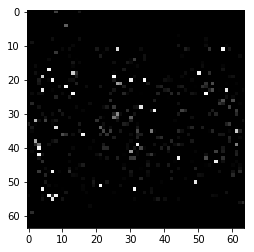

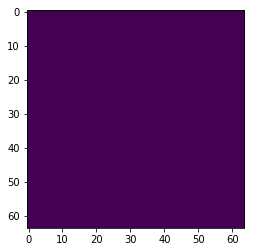

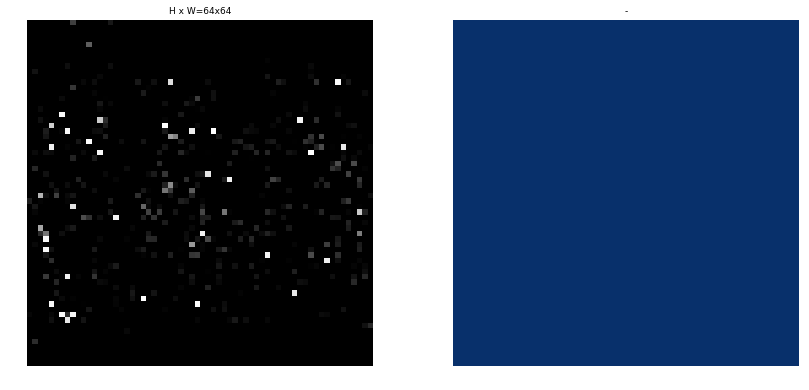

IndexError: list index out of range

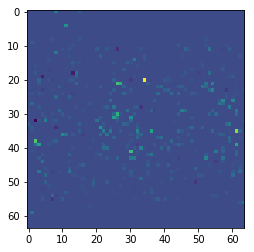

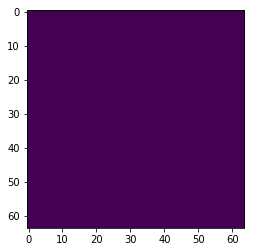

<Figure size 432x288 with 0 Axes>

In [21]:
image_id = np.random.choice(dataset_train.image_ids)
print('image id: ' + str(image_id))

image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
plt.imshow(image)
plt.figure()
plt.imshow(labels_train[image_id])
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

plt.imshow(images[image_id])
plt.figure()
plt.imshow(labels[image_id])
plt.figure()
 
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
  
  
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

image id: 517


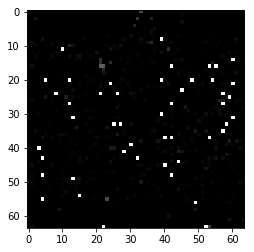

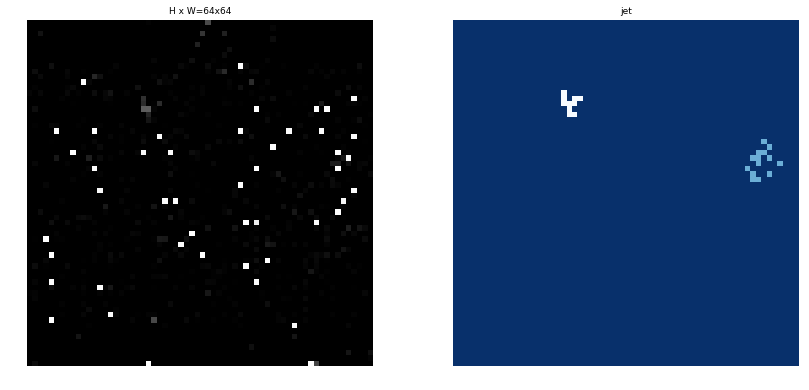

image id: 517
original_image           shape: (64, 64, 3)           min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  517.00000
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (2, 4)                min:   13.00000  max:   61.00000
gt_mask                  shape: (64, 64, 2)           min:    0.00000  max:    1.00000


TypeError: 'NoneType' object is not subscriptable

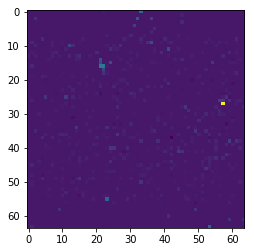

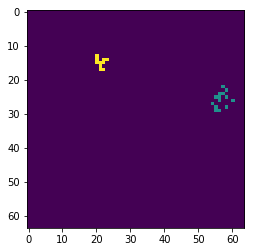

<Figure size 432x288 with 0 Axes>

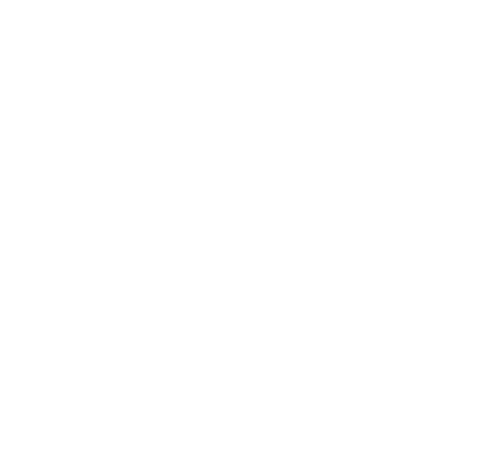

In [24]:
# Load and display random example from validation set

import visualize

image_id = random.choice(dataset_val.image_ids)
#image_id = 3


print('image id: ' + str(image_id))
image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
plt.imshow(image)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)


print('image id: ' + str(image_id))
plt.imshow(images[train_cutoff + image_id])
plt.figure()
plt.imshow(labels[train_cutoff + image_id])
plt.figure()

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))


Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  255.00000
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:   64.00000


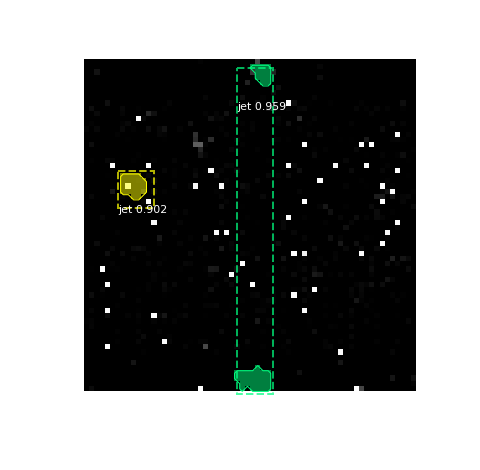

{'rois': array([[ 1, 29, 64, 36],
       [21,  6, 28, 13],
       [12,  7, 18, 63],
       [20, 21, 27, 30],
       [29, 23, 36, 31],
       [20, 55, 27, 62],
       [12, 19, 18, 26],
       [33, 37, 40, 44],
       [48, 13, 54, 50],
       [29, 57, 36, 62],
       [ 5, 25, 11, 40],
       [44, 13, 51, 49]], dtype=int32), 'class_ids': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'scores': array([0.9591842 , 0.9024545 , 0.8956695 , 0.88131773, 0.86507374,
       0.84025145, 0.8397534 , 0.7705207 , 0.7178832 , 0.71043855,
       0.70595443, 0.7041799 ], dtype=float32), 'masks': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0

In [25]:
import visualize
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


## Evaluation

In [17]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0


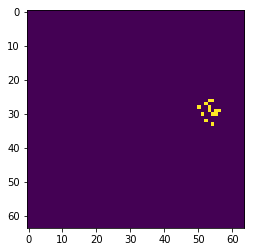

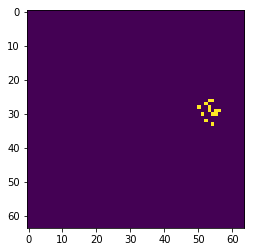

In [18]:
#Compute IoU
image_ids = [1]
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    true_masks, class_ids = dataset_val.load_mask(image_id)
    
    plt.figure()
    plt.imshow(true_masks[:,:,0])
    plt.figure()
    plt.imshow(gt_mask[:,:,0])